In [315]:
import os
import operator
from dotenv import load_dotenv
from typing import Annotated, List, Optional, Dict
from typing_extensions import TypedDict
from IPython.display import Image, Markdown
import markdown2
import json

from pydantic import BaseModel, Field
from langchain_groq import ChatGroq
from langchain_core.messages import SystemMessage
from langgraph.graph import StateGraph, START, END
from langchain_core.tools import tool



load_dotenv()
groq_api_key = os.getenv("GROQ_API_KEY")
llm = ChatGroq(model="llama3-70b-8192", api_key = groq_api_key)


In [316]:
class TripRequest(BaseModel) :
    """Schema for user's travel requests."""
    destination : str = Field(description= "The city or country for the trip.")
    days : int = Field(description= "The total number of days for the trip.")
    person : int = Field(description= "The total number of person who participate the trip")
    budget : Optional[float] = Field(description= "The estimated budget for the trip") 
    interests : Optional[List[str]] = Field(description= "A list of interests for the trip, e.g., []'art', 'history', 'food']." )
    

In [317]:
class FlightInfo(BaseModel) :
    """Schema for flight information"""
    airline : str = Field(description= "The name of the airline")
    price : float = Field(description= "The price of the round-trip flight")
    origin : str = Field(description= "The departure city")
    destination : str = Field(description= "The arrival city")


class HotelInfo(BaseModel):
    """Schema for hotel information."""
    hotel_name: str = Field(description="The name of the hotel.")
    price_per_night: float = Field(description="The price per night.")
    total_price: float = Field(description="The total price for the entire stay.")
    rating: float = Field(description="The hotel's rating out of 5.")


class Activity(BaseModel):
    """Schema for a single activity."""
    name: str = Field(description="Name of the activity or place.")
    description: str = Field(description="A brief description of the activity.")
    location: str = Field(description="Location or address of the activity.")
    time_of_day: str = Field(description="Suggested time of day, e.g., 'Morning', 'Afternoon', 'Evening'.")


class DailyPlan(BaseModel):
    """Schema for a single day's plan."""
    day: int = Field(description="The day number (e.g., 1, 2, 3).")
    activities: List[Activity] = Field(description="A list of activities for the day.")



class Itinerary(BaseModel):
    """The complete, final itinerary for the trip."""
    flight_info: FlightInfo
    hotel_info: HotelInfo
    daily_plans: List[DailyPlan]

In [318]:
class EvaluationResult(BaseModel):
    """Schema for the evaluation result."""
    is_within_budget: bool = Field(description="Whether the total cost is within the user's budget.")
    feedback: str = Field(description="Feedback on the plan, especially regarding the budget.")
    total_cost: float = Field(description="The calculated total cost of the trip.")

In [319]:

@tool
def flight_search_tool(destination: str, person: int) -> FlightInfo:
    """
    Searches for flights in flights.json based on destination.
    """
    print(f"--- Calling Flight Search Tool for {destination} for {person} people ---")
    
    file_path = os.path.join('mock_data', 'flights.json')
    with open(file_path, 'r') as f:
        flights_data = json.load(f)

    matching_flight = next((flight for flight in flights_data if flight['destination'].lower() == destination.lower()), None)

    if not matching_flight:
        return FlightInfo(airline="Not Found", price=0.0, origin="N/A", destination=destination)

    total_price = matching_flight['base_price_per_person'] * person
    
    return FlightInfo(
        airline=matching_flight['airline'],
        price=total_price,
        origin=matching_flight['origin'],
        destination=destination
    )





@tool
def hotel_search_tool(destination: str, days: int, person: int, refinement_attempt: int = 0) -> HotelInfo:
    """
    Searches for hotels in hotels.json.
    If it's a refinement attempt, it finds a cheaper hotel.
    """
    print(f"--- Calling Hotel Search Tool for {destination} (Refinement Attempt: {refinement_attempt}) ---")

    file_path = os.path.join('mock_data', 'hotels.json')
    with open(file_path, 'r') as f:
        hotels_data = json.load(f)

    matching_hotels = [hotel for hotel in hotels_data if hotel['destination'].lower() == destination.lower()]

    if not matching_hotels:
        return HotelInfo(hotel_name="Not Found", price_per_night=0, total_price=0, rating=0)

   
    matching_hotels.sort(key=lambda x: x['rating'], reverse=True)

 
    if refinement_attempt > 0 and len(matching_hotels) > refinement_attempt:
        
        selected_hotel = matching_hotels[refinement_attempt]
        print(f"-> Finding a cheaper hotel option: {selected_hotel['hotel_name']}")
    else:
        selected_hotel = matching_hotels[0]


    price_per_night = selected_hotel['price_per_night_for_two'] * (person / 2)
    total_price = price_per_night * (days - 1)

    return HotelInfo(
        hotel_name=selected_hotel['hotel_name'],
        price_per_night=price_per_night,
        total_price=total_price,
        rating=selected_hotel['rating']
    )



@tool
def activity_finder_tool(destination: str, interests: List[str]) -> List[Dict]:
    """Finds local activities from activities.json based on destination and interests."""
    print(f"--- Calling Activity Finder Tool for {destination} with interests: {interests} ---")
   
    file_path = os.path.join('mock_data', 'activities.json')
    with open(file_path, 'r') as f:
        activities_data = json.load(f)

    results = []
    
    for interest in interests:
        if interest.lower() in activities_data:
            results.extend(activities_data[interest.lower()])
            
    return results

In [320]:
class TripState(TypedDict):
    user_request: str
    trip_plan: Optional[TripRequest]
    flight_info: Optional[FlightInfo]
    hotel_info: Optional[HotelInfo]
    final_itinerary: Optional[Itinerary]
    evaluation_result: Optional[EvaluationResult] 
    refinement_count: int 
    markdown_report: Optional[str]

In [321]:
def planner_agent(state: TripState) -> dict:
    """
    Takes the user request and converts it into a structured TripRequest object.
    """
    print("--- Running Planner Agent ---")
    
    structured_llm = llm.with_structured_output(TripRequest)
    
    prompt = f"""
    Parse the following user request into a structured TripRequest object.
    Identify the destination, number of days, budget, and key interests.

    User Request: "{state['user_request']}"
    """
    
    plan = structured_llm.invoke(prompt)
    print(f"-> Structured Plan: {plan}")
    
    return {"trip_plan": plan}

In [322]:
def flight_agent(state: TripState) -> dict:
    """
    Takes the structured trip plan and uses the flight search tool to find flights.
    """
    print("--- Running Flight Agent ---")
    trip_plan = state['trip_plan']
    if not trip_plan:
        return {}


    flight_data = flight_search_tool.invoke({
        "destination": trip_plan.destination,
        "person": trip_plan.person
    })
    print(f"-> Flight Info: {flight_data}")

    return {"flight_info": flight_data}



def hotel_agent(state: TripState) -> dict:
    """
    Takes the structured trip plan and uses the hotel search tool to find hotels.
    """
    print("--- Running Hotel Agent ---")
    trip_plan = state['trip_plan']
    refinement_count = state.get('refinement_count', 0)
    hotel_data = hotel_search_tool.invoke({"destination": trip_plan.destination, "days": trip_plan.days, "person": trip_plan.person, "refinement_attempt": refinement_count})
    print(f"-> Hotel Info: {hotel_data}")
    return {"hotel_info": hotel_data}

In [323]:
def aggregator_agent(state: TripState) -> dict:
    """
    Aggregates the results from parallel agents.
    """
    print("--- Running Aggregator Agent ---")
    print("-> Aggregated Flight Info:", state.get('flight_info'))
    print("-> Aggregated Hotel Info:", state.get('hotel_info'))
    return {}

In [324]:
def activity_planner_agent(state: TripState) -> dict:
    """
    Uses the activity finder tool and then creates a structured daily itinerary.
    """
    print("--- Running Activity Planner Agent ---")
    trip_plan = state['trip_plan']
    if not trip_plan: return {}
    
    
    activities = activity_finder_tool.invoke({
        "destination": trip_plan.destination,
        "interests": trip_plan.interests
    })
    
    planner_llm = llm.with_structured_output(Itinerary)
    prompt = f"""
    You are an expert travel planner. Create a detailed, day-by-day itinerary for a trip based on the provided information.
    Organize the suggested activities into a logical schedule for the given number of days.
    Group activities that are geographically close to each other on the same day.
    Ensure the final output is a complete Itinerary object, including the provided flight and hotel information.

    Trip Information:
    - Destination: {trip_plan.destination}
    - Duration: {trip_plan.days} days
    - Flight Info: {state['flight_info'].model_dump()}
    - Hotel Info: {state['hotel_info'].model_dump()}

    Available Activities (choose and schedule from this list):
    {activities}
    """
    
    final_itinerary = planner_llm.invoke(prompt)
    print("-> Final Itinerary Created")
    
    return {"final_itinerary": final_itinerary}

In [325]:
def evaluator_agent(state: TripState) -> dict:
    """Evaluates the generated itinerary against the user's budget."""
    print("--- Running Evaluator Agent ---")
    trip_plan = state['trip_plan']
    flight_info = state['flight_info']
    hotel_info = state['hotel_info']
    
    if not all([trip_plan, flight_info, hotel_info]):
        return {"evaluation_result": EvaluationResult(is_within_budget=False, feedback="Missing information to evaluate budget.", total_cost=0)}

    total_cost = flight_info.price + hotel_info.total_price
    budget = trip_plan.budget

    evaluator_llm = llm.with_structured_output(EvaluationResult)
    prompt = f"""
    You are a budget compliance checker. Evaluate if the total cost of a trip is within the user's budget.

    User's Budget: €{budget}
    Total Calculated Cost: €{total_cost} (Flight: €{flight_info.price} + Hotel: €{hotel_info.total_price})

    Is the plan within budget? Provide a boolean answer and brief feedback.
    """
    result = evaluator_llm.invoke(prompt)
    print(f"-> Evaluation Result: Budget OK? {result.is_within_budget}. Feedback: {result.feedback}")
    
    refinement_count = state.get('refinement_count', 0) + 1
    
    return {"evaluation_result": result, "refinement_count": refinement_count}




MAX_REFINEMENTS = 2
def should_refine_or_end(state: TripState):
    """Decides whether to end the process or loop back to refine the plan."""
    print("--- Checking for Refinement ---")
    is_within_budget = state["evaluation_result"].is_within_budget
    count = state.get('refinement_count', 0)
    
    if is_within_budget:
        print("-> Plan is within budget. Finishing.")
        return "end"
    elif count >= MAX_REFINEMENTS:
        print(f"-> Max refinements ({MAX_REFINEMENTS}) reached. Finishing with over-budget plan.")
        return "end"
    else:
        print(f"-> Plan is over budget. Looping back to find cheaper options (Attempt {count}).")
        return "refine"

In [326]:
def report_formatter_node(state: TripState) -> dict:
    """
    Takes the final Itinerary object and formats it into a Markdown report
    and a styled HTML file.
    """
    print("--- Running Report Formatter ---")
    
    itinerary = state.get("final_itinerary")
    if not itinerary:
        final_report_md = "# Trip Plan Generation Failed\n\nCould not generate a valid itinerary within the given constraints."
    else:
        trip_plan = state.get("trip_plan")
        
        md = f"# Your Trip to {trip_plan.destination}\n\n"
        md += f"A {trip_plan.days}-day trip for {trip_plan.person} people, focusing on {', '.join(trip_plan.interests)}.\n\n"
        
        md += "## ✈️ Flight Information\n"
        md += f"- **Airline:** {itinerary.flight_info.airline}\n"
        md += f"- **Origin:** {itinerary.flight_info.origin}\n"
        md += f"- **Total Price:** €{itinerary.flight_info.price:.2f}\n\n"
        
        md += "## 🏨 Hotel Information\n"
        md += f"- **Hotel Name:** {itinerary.hotel_info.hotel_name}\n"
        md += f"- **Rating:** {itinerary.hotel_info.rating} / 5.0\n"
        md += f"- **Total Price for Stay:** €{itinerary.hotel_info.total_price:.2f}\n\n"
        
        md += "---\n\n## 🗺️ Daily Itinerary\n"
        for day_plan in itinerary.daily_plans:
            md += f"\n### Day {day_plan.day}\n"
            for activity in day_plan.activities:
                md += f"- **{activity.time_of_day}: {activity.name}**\n"
                md += f"  - *{activity.description}*\n"
                md += f"  - Location: {activity.location}\n"
        final_report_md = md

    css_style = """<style> body { font-family: -apple-system, BlinkMacSystemFont, "Segoe UI", Roboto, Helvetica, Arial, sans-serif; line-height: 1.6; color: #333; max-width: 800px; margin: 40px auto; padding: 20px; background-color: #f9f9f9; } h1, h2, h3 { color: #2c3e50; border-bottom: 2px solid #ecf0f1; padding-bottom: 10px; } h1 { font-size: 2.5em; } h2 { font-size: 2em; } </style>"""
    html_body = markdown2.markdown(final_report_md, extras=["tables", "fenced-code-blocks"])
    report_title = state.get("trip_plan").destination if state.get("trip_plan") else "AI Travel Plan"
    full_html = f'<!DOCTYPE html><html lang="en"><head><meta charset="UTF-8"><title>{report_title}</title>{css_style}</head><body><h1>Trip to {report_title}</h1>{html_body}</body></html>'

    output_dir = "output"
    os.makedirs(output_dir, exist_ok=True) 

    md_path = os.path.join(output_dir, "trip_itinerary.md")
    html_path = os.path.join(output_dir, "trip_itinerary.html")

    
    try:
        with open(md_path , "w", encoding="utf-8") as f:
            f.write(final_report_md)
        print("-> Markdown report saved to trip_itinerary.md")

        with open(html_path , "w", encoding="utf-8") as f:
            f.write(full_html)
        print("-> HTML report saved to trip_itinerary.html")
    except Exception as e:
        print(f"Error saving files: {e}")

    return {"markdown_report": final_report_md}

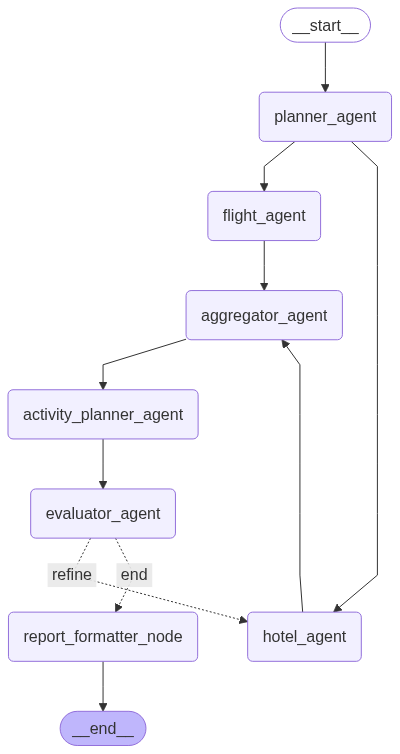

In [327]:
workflow = StateGraph(TripState)


workflow.add_node("planner_agent", planner_agent)
workflow.add_node("flight_agent", flight_agent)
workflow.add_node("hotel_agent", hotel_agent) 
workflow.add_node("aggregator_agent", aggregator_agent) 
workflow.add_node("activity_planner_agent", activity_planner_agent)
workflow.add_node("evaluator_agent", evaluator_agent)
workflow.add_node("report_formatter_node", report_formatter_node) 


workflow.add_edge(START, "planner_agent")

workflow.add_edge("planner_agent", "flight_agent")
workflow.add_edge("planner_agent", "hotel_agent")

workflow.add_edge(["flight_agent", "hotel_agent"], "aggregator_agent")

workflow.add_edge("aggregator_agent", "activity_planner_agent")
workflow.add_edge("activity_planner_agent", "evaluator_agent")

workflow.add_conditional_edges(
    "evaluator_agent",
    should_refine_or_end,
    {
        "refine": "hotel_agent", 
        "end": "report_formatter_node"              
    }
)

workflow.add_edge("report_formatter_node", END)


app = workflow.compile()

display(Image(app.get_graph().draw_mermaid_png()))

In [329]:
user_query = "I want to plan a 6-day trip to New York with my two best friends. We are interested in adventure and food, and our total budget is around 10000 euros."
initial_state = {"user_request": user_query}
final_state = app.invoke(initial_state, config={"recursion_limit" : 50})

print("\n--- FINAL REPORT ---")

final_markdown_report = final_state.get("markdown_report", "No report was generated.")
display(Markdown(final_markdown_report))

--- Running Planner Agent ---
-> Structured Plan: destination='New York' days=6 person=3 budget=10000.0 interests=['adventure', 'food']
--- Running Flight Agent ---
--- Calling Flight Search Tool for New York for 3 people ---
--- Running Hotel Agent ---
--- Calling Hotel Search Tool for New York (Refinement Attempt: 0) ---
-> Hotel Info: hotel_name='Times Square Lux Suites' price_per_night=675.0 total_price=3375.0 rating=4.7
-> Flight Info: airline='Lufthansa' price=2850.0 origin='Antalya' destination='New York'
--- Running Aggregator Agent ---
-> Aggregated Flight Info: airline='Lufthansa' price=2850.0 origin='Antalya' destination='New York'
-> Aggregated Hotel Info: hotel_name='Times Square Lux Suites' price_per_night=675.0 total_price=3375.0 rating=4.7
--- Running Activity Planner Agent ---
--- Calling Activity Finder Tool for New York with interests: ['adventure', 'food'] ---
-> Final Itinerary Created
--- Running Evaluator Agent ---
-> Evaluation Result: Budget OK? True. Feedback:

# Your Trip to New York

A 6-day trip for 3 people, focusing on adventure, food.

## ✈️ Flight Information
- **Airline:** Lufthansa
- **Origin:** Antalya
- **Total Price:** €2850.00

## 🏨 Hotel Information
- **Hotel Name:** Times Square Lux Suites
- **Rating:** 4.7 / 5.0
- **Total Price for Stay:** €3375.00

---

## 🗺️ Daily Itinerary

### Day 1
- **Morning: Explore Times Square**
  - *Start your trip by exploring the iconic Times Square.*
  - Location: New York
- **Afternoon: Walk across the Brooklyn Bridge**
  - *Take in the stunning Manhattan skyline views.*
  - Location: New York

### Day 2
- **Morning: Visit the Statue of Liberty**
  - *Take a ferry to Liberty Island to see the iconic statue.*
  - Location: New York
- **Afternoon: Central Park Stroll**
  - *Relax in the tranquil surroundings of Central Park.*
  - Location: New York

### Day 3
- **Morning: 9/11 Memorial & Museum**
  - *Pay respects at the poignant memorial and museum.*
  - Location: New York
- **Afternoon: Broadway Show**
  - *Catch a matinee or evening performance of a hit Broadway show.*
  - Location: New York

### Day 4
- **Morning: Metropolitan Museum of Art**
  - *Spend the day exploring the world-class museum.*
  - Location: New York
- **Afternoon: High Line Walk**
  - *Stroll along the elevated park built on an old rail line.*
  - Location: New York

### Day 5
- **Morning: Rockefeller Center Tour**
  - *Learn about the history and significance of the iconic center.*
  - Location: New York
- **Afternoon: Shopping in SoHo**
  - *Browse the trendy boutiques and art galleries.*
  - Location: New York

### Day 6
- **Morning: One World Trade Center Observation Deck**
  - *Take in panoramic views of the city from the tallest building.*
  - Location: New York
- **Evening: Farewell Dinner in Little Italy**
  - *Enjoy a delicious Italian meal before departing.*
  - Location: New York
